In [1]:
import pandas as pd
import numpy as np
import gensim
import os
from pathlib import Path
from gensim.models.doc2vec import *
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colorlover as cl
from IPython.display import HTML
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
import ipywidgets as widgets
from collections import Counter
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from sklearn.cross_validation import KFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning:

compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5

/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
vectorized_df = pd.read_csv('document_vectors_df.csv', index_col = 0)
vectorized_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,author,sex,period
0,-1.970910,0.848074,-0.440028,0.857539,-0.124459,-0.851813,0.138067,-3.733878,-1.866872,-0.703593,...,0.659864,-0.437961,0.722089,0.347195,1.313847,2.680759,-0.379815,MaryWollstonecraft,female,enlightenment
1,-0.510864,-0.622333,-0.736651,0.613865,0.368931,-0.391960,-0.469377,-2.290867,-0.881997,-0.096872,...,-0.259618,0.989194,0.650732,-0.696870,0.742644,1.306955,2.271753,MaryWollstonecraft,female,enlightenment
2,-1.192763,-0.101330,-2.033015,-0.657394,-2.957540,-1.393376,0.922216,-1.949090,0.973241,-0.010799,...,1.731215,-2.687085,1.006650,0.577892,-2.256335,-0.870119,1.854182,MaryWollstonecraft,female,enlightenment
3,-1.638204,2.475540,2.761713,-0.208285,1.245777,-1.857539,1.301273,-0.596133,-0.471881,1.390386,...,-0.255897,0.055352,1.467543,0.755759,1.035357,0.322843,1.942936,MaryWollstonecraft,female,enlightenment
4,-3.274428,-0.990834,-2.353368,1.261691,-2.174409,-0.996711,1.268803,-2.305384,0.418952,1.774418,...,2.602762,-0.780936,1.422385,-1.050799,-0.209620,-0.086764,1.308790,MaryWollstonecraft,female,enlightenment


In [3]:
authors = list(set((vectorized_df['author'])))
genders = list(set((vectorized_df['sex'])))
periods = list(set((vectorized_df['period'])))

In [6]:
# create author, gender, period dictionaries for mapping 
num = list(range(0,len(authors)))
author_num = dict(zip(authors, num))

num_gen = list(range(0,len(genders)))
sex_num = dict(zip(genders, num_gen))

num_period = list(range(0,len(periods)))
period_num = dict(zip(periods, num_period))

In [7]:
vectorized_df['sex'] = vectorized_df['sex'].map(sex_num)
vectorized_df['author'] = vectorized_df['author'].map(author_num)
vectorized_df['period'] = vectorized_df['period'].map(period_num)

In [8]:
X = vectorized_df.drop(['author', 'sex', 'period'], axis = 1)
y_author = vectorized_df['author']
y_period = vectorized_df['period']

In [9]:
X_train_author, X_test_author, y_train_author, y_test_author = train_test_split(X, y_author)
X_train_period, X_test_period, y_train_period, y_test_period = train_test_split(X, y_period)

In [10]:
freq_train_author = [sum(y_train_author == i) for i in range(0, len(authors))]
freq_test_author = [sum(y_test_author == i) for i in range(0, len(authors))]
freq_train_period = [sum(y_train_period == i) for i in range(0, len(periods))]
freq_test_period = [sum(y_test_period == i) for i in range(0, len(periods))]

<IPython.core.display.Javascript object>


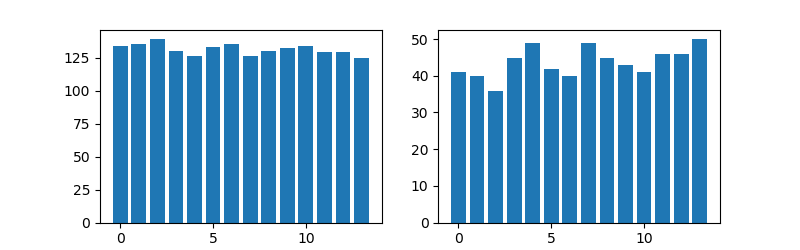

In [11]:
# checking the class inbalance
%matplotlib notebook
plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.bar(list(range(0,len(authors))), freq_train_author)
plt.show()
plt.subplot(122)
plt.bar(list(range(0,len(authors))), freq_test_author)
plt.show()

<IPython.core.display.Javascript object>


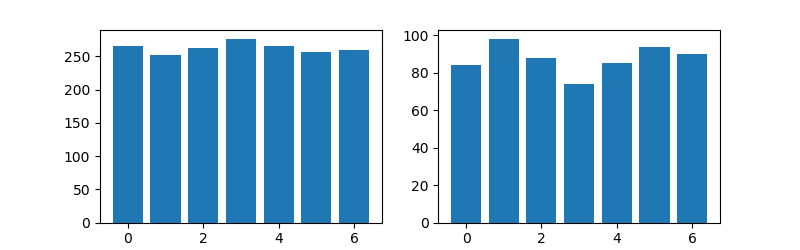

In [12]:
# checking the class inbalance
%matplotlib notebook
plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.bar(list(range(0,len(periods))), freq_train_period)
plt.show()
plt.subplot(122)
plt.bar(list(range(0,len(periods))), freq_test_period)
plt.show()

## Shallow Learning Classifiers
#### K - Nearest Neighbors
- Author Classification

### Getting & Processing Data

In [13]:
df = pd.read_csv(Path.cwd().joinpath('250Paragraphs_150Words.csv'), index_col = 0)

sliced_df = df.loc[:, 'text']
labels_sex = df.loc[:, 'sex']
labels_period = df.loc[:, 'period']
labels_author = df.loc[:, 'author']

#note that we can call all_labels and see our names, should we forget them later
all_labels = {'sex': labels_sex, 'period': labels_period, 'author': labels_author}

### Bag of Words & TF-IDF

In [14]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
# max_df and min_df work interestingly
# they can either be a float value between 0.0 and 1.0
# in which case they represent a proportion of the documents - i.e. .98 = 98% of the docs
# or they can be an integer
# in which case they can be an absolute count - i.e. 2 = 2 out of all documents

In [16]:
# I'm creating this dictionary so the transformed vectors can be easily referenced throughout the doc
transformed_vectors = {}

In [17]:
#Bag of Words without n-grams

count_vec = CountVectorizer(min_df = 2, max_df = .98, stop_words="english")
count_vec.fit(sliced_df)
count_vec_transformed = count_vec.transform(sliced_df)
transformed_vectors['count_vec_transformed'] = count_vec_transformed

In [18]:
# Taking a look at our transformed data - a sparse matrix 
count_vec_transformed

<3500x14125 sparse matrix of type '<class 'numpy.int64'>'
	with 184397 stored elements in Compressed Sparse Row format>

In [19]:
#Bag of Words - bigrams

count_vec_bigrams = CountVectorizer(min_df = 2, max_df = .98, stop_words="english", ngram_range=(1,2))
count_vec_bigrams.fit(sliced_df)
count_vec_bigrams_transformed = count_vec_bigrams.transform(sliced_df)
transformed_vectors['count_vec_bigrams_transformed'] = count_vec_bigrams_transformed

In [20]:
#Bag of Words - trigrams

count_vec_trigrams = CountVectorizer(min_df = 2, max_df = .98, stop_words="english", ngram_range=(1,3))
count_vec_trigrams.fit(sliced_df)
count_vec_trigrams_transformed = count_vec_trigrams.transform(sliced_df)
transformed_vectors['count_vec_trigrams_transformed'] = count_vec_trigrams_transformed

In [21]:
#TFIDF without n-grams

tfidf_vec = TfidfVectorizer(min_df = 2, max_df = .98, stop_words='english')
tfidf_vec.fit(sliced_df)
tfidf_vec_transformed = tfidf_vec.transform(sliced_df)
transformed_vectors['tfidf_vec_transformed'] = tfidf_vec_transformed

In [22]:
#TFIDF - bigrams

tfidf_vec_bigrams = TfidfVectorizer(min_df = 2, max_df = .98, stop_words='english', ngram_range=(1,2))
tfidf_vec_bigrams.fit(sliced_df)
tfidf_vec_bigrams_transformed = tfidf_vec.transform(sliced_df)
transformed_vectors['tfidf_vec_bigrams_transformed'] = tfidf_vec_bigrams_transformed

In [23]:
#TFIDF - trigrams

tfidf_vec_trigrams = TfidfVectorizer(min_df = 2, max_df = .98, stop_words='english', ngram_range=(1,3))
tfidf_vec_trigrams.fit(sliced_df)
tfidf_vec_trigrams_transformed = tfidf_vec.transform(sliced_df)
transformed_vectors['tfidf_vec_trigrams_transformed'] = tfidf_vec_trigrams_transformed

In [24]:
transformed_vectors_all = transformed_vectors

# trigrams didn't add much to our accuracy and added a lot of computational power / time, so we deleted them
# but obviously they could also be left in, and other matrices could be added. 

del transformed_vectors['tfidf_vec_trigrams_transformed']
del transformed_vectors['count_vec_trigrams_transformed']

In [25]:
tfidf_vec_bigrams_transformed

<3500x14125 sparse matrix of type '<class 'numpy.float64'>'
	with 184397 stored elements in Compressed Sparse Row format>

### Pipeline Implementation - Classifiers for Author & Period

In [26]:
#Functions 

def test_classifiers(transformed_vectors, grid, labels):
    results_dict = {}
    
    for named_matrix, sparse_matrix in transformed_vectors.items():
        X_train, X_test, y_train, y_test = train_test_split(sparse_matrix, labels)
        grid.fit(X_train, y_train)
        results_dict[named_matrix + ' results'] = [grid.best_score_, grid.best_params_, grid.score(X_train, y_train), grid.score(X_test, y_test)]
    
    return results_dict

def run_multi_naive_bayes(transformed_vectors, labels):
    results_dict = {}
    
    mnb_clf = MultinomialNB()
    
    for named_matrix, sparse_matrix in transformed_vectors.items():
        X_train, X_test, y_train, y_test = train_test_split(sparse_matrix, labels)
        mnb_clf.fit(X_train, y_train)
        mnb_clf_train_preds = mnb_clf.predict(X_train)
        mnb_clf_test_preds = mnb_clf.predict(X_test)
        mnb_clf_train_accuracy = accuracy_score(y_train, mnb_clf_train_preds)
        mnb_clf_test_accuracy = accuracy_score(y_test, mnb_clf_test_preds)
        results_dict[named_matrix + ' results'] = [mnb_clf_train_accuracy, mnb_clf_test_accuracy]
        
    return results_dict

def run_bern_naive_bayes(transformed_vectors, labels):
    results_dict = {}
    
    bernoulli_clf = BernoulliNB()
    
    for named_matrix, sparse_matrix in transformed_vectors.items():
        X_train, X_test, y_train, y_test = train_test_split(sparse_matrix, labels)
        bernoulli_clf.fit(X_train, y_train)
        bernoulli_train_preds = bernoulli_clf.predict(X_train)
        bernoulli_test_preds = bernoulli_clf.predict(X_test)
        bernoulli_train_accuracy = accuracy_score(y_train, bernoulli_train_preds)
        bernoulli_test_accuracy = accuracy_score(y_test, bernoulli_test_preds)
        results_dict[named_matrix + ' results'] = [bernoulli_train_accuracy, bernoulli_test_accuracy]
        
    return results_dict

### Naive Bayes

Ran multiple versions. All testing was classification on sex (binary). Multi-categorical classification (period and author) was done with ensemble methdods.

In [29]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

##### NB Function Calls

In [30]:
mulitnomial_nb_results = run_multi_naive_bayes(transformed_vectors, all_labels['sex'])

In [31]:
bernoulli_nb_results = run_bern_naive_bayes(transformed_vectors, all_labels['sex'])

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier 

In [33]:
# RandomForestClassifier??

In [34]:
rf_param_grid = {'randomforestclassifier__n_estimators': [150, 250, 350], 
                'randomforestclassifier__max_depth': [5, 10, 15]}

rf_pipe = make_pipeline(RandomForestClassifier())

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv = 5, scoring = "accuracy")

In [35]:
%%time
rf_author_results = test_classifiers(transformed_vectors, rf_grid, all_labels['author'])

CPU times: user 4min 27s, sys: 1.58 s, total: 4min 28s
Wall time: 4min 33s


In [36]:
%%time
rf_period_results = test_classifiers(transformed_vectors, rf_grid, all_labels['period'])

CPU times: user 4min 18s, sys: 1.13 s, total: 4min 19s
Wall time: 4min 22s


In [37]:
%%time
rf_sex_results = test_classifiers(transformed_vectors, rf_grid, all_labels['sex'])

CPU times: user 4min 9s, sys: 1.88 s, total: 4min 11s
Wall time: 4min 15s


### Adaboost

In [154]:
from sklearn.ensemble import AdaBoostClassifier

In [155]:
ada = AdaBoostClassifier()

ada_param_grid = {'adaboostclassifier__n_estimators': [50, 150, 250], 
                 'adaboostclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]}

ada_pipe = make_pipeline(ada)

ada_grid = GridSearchCV(ada_pipe, ada_param_grid, cv = 5, scoring = "accuracy")

In [156]:
%%time
ada_author_results = test_classifiers(transformed_vectors, ada_grid, all_labels['author'])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [157]:
%%time
ada_period_results = test_classifiers(transformed_vectors, ada_grid, all_labels['period'])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 16 µs


In [158]:
%%time
ada_sex_results = test_classifiers(transformed_vectors, ada_grid, all_labels['sex'])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


### K-Neighbors

In [69]:
n_neighbors = 100

scores = []
for weight in ['uniform', 'distance']:
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weight)
    clf.fit(X_train_author, y_train_author)
    y_hat = clf.score(X_train_author, y_train_author)
    scores.append(y_hat)

In [70]:
scores

[0.5264017419706043, 1.0]

### Examining Results 

In [162]:
mulitnomial_nb_results

{'count_vec_bigrams_transformed results': [0.9935238095238095,
  0.8754285714285714],
 'count_vec_transformed results': [0.9836190476190476, 0.8845714285714286],
 'tfidf_vec_bigrams_transformed results': [0.9767619047619047,
  0.8674285714285714],
 'tfidf_vec_transformed results': [0.976, 0.8708571428571429]}

In [163]:
bernoulli_nb_results

{'count_vec_bigrams_transformed results': [0.9969523809523809, 0.904],
 'count_vec_transformed results': [0.9870476190476191, 0.8914285714285715],
 'tfidf_vec_bigrams_transformed results': [0.9897142857142858,
  0.8765714285714286],
 'tfidf_vec_transformed results': [0.9900952380952381, 0.864]}

In [164]:
ada_sex_results

{'count_vec_bigrams_transformed results': [0.7687619047619048,
  {'adaboostclassifier__learning_rate': 1,
   'adaboostclassifier__n_estimators': 250},
  0.7794285714285715],
 'count_vec_transformed results': [0.7828571428571428,
  {'adaboostclassifier__learning_rate': 1,
   'adaboostclassifier__n_estimators': 250},
  0.7508571428571429],
 'tfidf_vec_bigrams_transformed results': [0.7390476190476191,
  {'adaboostclassifier__learning_rate': 1,
   'adaboostclassifier__n_estimators': 250},
  0.7828571428571428],
 'tfidf_vec_transformed results': [0.7573333333333333,
  {'adaboostclassifier__learning_rate': 1,
   'adaboostclassifier__n_estimators': 250},
  0.7805714285714286]}

In [166]:
ada_period_results

{'count_vec_bigrams_transformed results': [0.43923809523809526,
  {'adaboostclassifier__learning_rate': 0.1,
   'adaboostclassifier__n_estimators': 150},
  0.4297142857142857],
 'count_vec_transformed results': [0.43047619047619046,
  {'adaboostclassifier__learning_rate': 0.1,
   'adaboostclassifier__n_estimators': 250},
  0.45371428571428574],
 'tfidf_vec_bigrams_transformed results': [0.42438095238095236,
  {'adaboostclassifier__learning_rate': 0.1,
   'adaboostclassifier__n_estimators': 150},
  0.424],
 'tfidf_vec_transformed results': [0.41409523809523807,
  {'adaboostclassifier__learning_rate': 0.1,
   'adaboostclassifier__n_estimators': 150},
  0.4297142857142857]}

In [167]:
ada_author_results

{'count_vec_bigrams_transformed results': [0.3264761904761905,
  {'adaboostclassifier__learning_rate': 0.1,
   'adaboostclassifier__n_estimators': 250},
  0.3291428571428571],
 'count_vec_transformed results': [0.3139047619047619,
  {'adaboostclassifier__learning_rate': 0.01,
   'adaboostclassifier__n_estimators': 250},
  0.3017142857142857],
 'tfidf_vec_bigrams_transformed results': [0.33485714285714285,
  {'adaboostclassifier__learning_rate': 0.01,
   'adaboostclassifier__n_estimators': 250},
  0.32],
 'tfidf_vec_transformed results': [0.3222857142857143,
  {'adaboostclassifier__learning_rate': 0.01,
   'adaboostclassifier__n_estimators': 250},
  0.3062857142857143]}

In [168]:
rf_sex_results

{'count_vec_bigrams_transformed results': [0.8053333333333333,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.8125714285714286],
 'count_vec_transformed results': [0.8091428571428572,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.7862857142857143],
 'tfidf_vec_bigrams_transformed results': [0.772952380952381,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 250},
  0.7977142857142857],
 'tfidf_vec_transformed results': [0.7782857142857142,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 250},
  0.7611428571428571]}

In [169]:
rf_period_results

{'count_vec_bigrams_transformed results': [0.6346666666666667,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.6525714285714286],
 'count_vec_transformed results': [0.6209523809523809,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 250},
  0.64],
 'tfidf_vec_bigrams_transformed results': [0.6076190476190476,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.5897142857142857],
 'tfidf_vec_transformed results': [0.6102857142857143,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.6137142857142858]}

In [170]:
rf_author_results

{'count_vec_bigrams_transformed results': [0.5874285714285714,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 250},
  0.6034285714285714],
 'count_vec_transformed results': [0.5805714285714285,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.5737142857142857],
 'tfidf_vec_bigrams_transformed results': [0.5691428571428572,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 250},
  0.5828571428571429],
 'tfidf_vec_transformed results': [0.5748571428571428,
  {'randomforestclassifier__max_depth': 15,
   'randomforestclassifier__n_estimators': 350},
  0.5988571428571429]}